# Movie Recommendation System using Collaborative Filtering

This notebook implements a movie recommendation system using collaborative filtering techniques. We'll use the MovieLens dataset to build and evaluate our recommendation model.

## 1. Import Libraries

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

# Set plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')
%matplotlib inline

## 2. Load and Explore the Dataset

We'll use the MovieLens 100K dataset which contains 100,000 ratings from 943 users on 1,682 movies.

In [7]:
# Download the MovieLens dataset
# !wget -q -O ml-100k.zip "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
# !unzip -q ml-100k.zip

# Load the ratings data
ratings_df = pd.read_csv('db/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Load movie information
movies_df = pd.read_csv('db/ml-100k/u.item', sep='|', encoding='latin-1', 
                        names=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + 
                        [f'genre_{i}' for i in range(19)])

# Display the first few rows of each dataframe
print("Ratings dataframe:")
ratings_df.head()

Ratings dataframe:


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
# Display movie information
print("Movies dataframe:")
movies_df[['movie_id', 'title', 'release_date']].head()

Movies dataframe:


,movie_id,title,release_date
0,1,Toy Story (1995),01-Jan-1995
1,2,GoldenEye (1995),01-Jan-1995
2,3,Four Rooms (1995),01-Jan-1995
3,4,Get Shorty (1995),01-Jan-1995
4,5,Copycat (1995),01-Jan-1995


In [9]:
# Basic statistics about the dataset
print(f"Number of users: {ratings_df['user_id'].nunique()}")
print(f"Number of movies: {ratings_df['movie_id'].nunique()}")
print(f"Number of ratings: {len(ratings_df)}")
print(f"Rating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")

Number of users: 943
Number of movies: 1682
Number of ratings: 100000
Rating range: 1 to 5
Average rating: 3.53


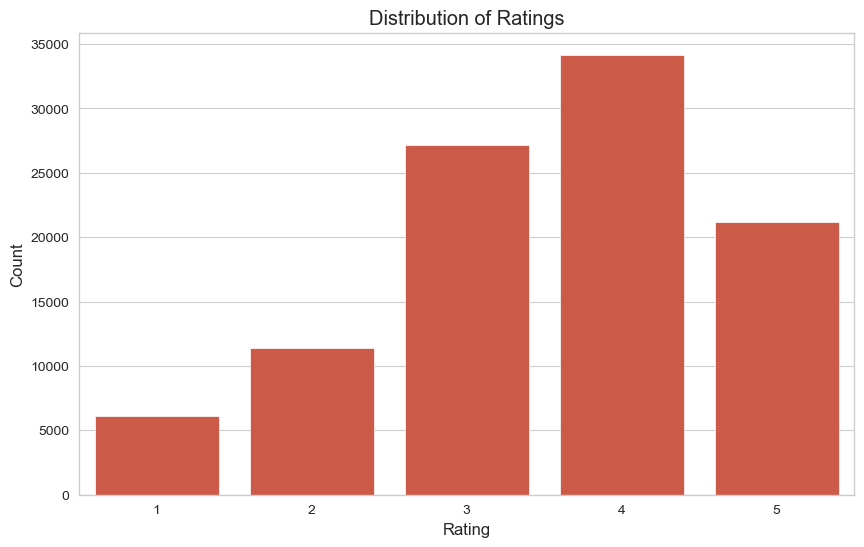

In [10]:
# Visualize the rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## 3. Data Preprocessing

In [11]:
# Create a user-item matrix
user_movie_matrix = ratings_df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
print(f"User-Movie Matrix Shape: {user_movie_matrix.shape}")
user_movie_matrix.head()

User-Movie Matrix Shape: (943, 1682)


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Check sparsity of the matrix
sparsity = 1.0 - len(ratings_df) / (user_movie_matrix.shape[0] * user_movie_matrix.shape[1])
print(f"Matrix sparsity: {sparsity:.2%}")

Matrix sparsity: 93.70%


## 4. Train-Test Split for Evaluation

In [13]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (80000, 4)
Testing data shape: (20000, 4)


In [14]:
# Create user-item matrices for training data
train_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# Convert to numpy arrays
train_matrix_np = train_matrix.to_numpy()

# Get the mean rating for each user
user_ratings_mean = np.mean(train_matrix_np, axis=1)

# Center the ratings by subtracting the mean (normalization)
train_matrix_centered = train_matrix_np - user_ratings_mean.reshape(-1, 1)

## 5. Collaborative Filtering Implementation

### 5.1 Matrix Factorization using Singular Value Decomposition (SVD)

In [15]:
# Perform SVD on the centered matrix
U, sigma, Vt = svds(train_matrix_centered, k=50)  # k is the number of latent factors

# Convert sigma to a diagonal matrix
sigma = np.diag(sigma)

# Reconstruct the prediction matrix
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

# Convert the prediction matrix back to a DataFrame
preds_df = pd.DataFrame(all_user_predicted_ratings, index=train_matrix.index, columns=train_matrix.columns)

print("Predicted ratings matrix shape:", preds_df.shape)

Predicted ratings matrix shape: (943, 1653)


### 5.2 User-Based Collaborative Filtering

In [16]:
# Calculate user-user similarity matrix using cosine similarity
user_similarity = cosine_similarity(train_matrix_np)
user_similarity_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)

print("User similarity matrix shape:", user_similarity_df.shape)
user_similarity_df.iloc[:5, :5]  # Show a sample of the similarity matrix

User similarity matrix shape: (943, 943)


user_id,1,2,3,4,5
user_id,,,,,
1,1.000000,0.136196,0.030424,0.026203,0.284613
2,0.136196,1.000000,0.114644,0.168220,0.093128
3,0.030424,0.114644,1.000000,0.346894,0.000000
4,0.026203,0.168220,0.346894,1.000000,0.011848
5,0.284613,0.093128,0.000000,0.011848,1.000000


## 6. Recommendation Functions

In [17]:
def recommend_movies_svd(user_id, num_recommendations=10):
    """
    Recommends movies for a specific user using SVD-based collaborative filtering.
    
    Args:
        user_id: The ID of the user to recommend movies for
        num_recommendations: Number of recommendations to return
        
    Returns:
        DataFrame with recommended movies and their predicted ratings
    """
    # Get the user's predictions
    user_row_number = train_matrix.index.get_loc(user_id)
    user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's watched movies
    user_data = ratings_df[ratings_df.user_id == user_id]
    user_watched = user_data['movie_id'].unique()
    
    # Filter out already watched movies
    recommendations = user_predictions[~user_predictions.index.isin(user_watched)]
    
    # Get movie titles and join with recommendations
    movie_titles = movies_df[['movie_id', 'title']]
    recommendations = pd.DataFrame(recommendations).reset_index()
    recommendations.columns = ['movie_id', 'predicted_rating']
    recommendations = recommendations.merge(movie_titles, on='movie_id')
    
    return recommendations.sort_values('predicted_rating', ascending=False).head(num_recommendations)

In [18]:
def recommend_movies_user_based(user_id, num_recommendations=10, k=30):
    """
    Recommends movies for a specific user using user-based collaborative filtering.
    
    Args:
        user_id: The ID of the user to recommend movies for
        num_recommendations: Number of recommendations to return
        k: Number of similar users to consider
        
    Returns:
        DataFrame with recommended movies and their predicted ratings
    """
    # Get the user's row index
    user_idx = train_matrix.index.get_loc(user_id)
    
    # Get the k most similar users
    similar_users = user_similarity_df.iloc[user_idx].sort_values(ascending=False).index[1:k+1]
    
    # Get the user's watched movies
    user_data = ratings_df[ratings_df.user_id == user_id]
    user_watched = user_data['movie_id'].unique()
    
    # Get ratings from similar users for movies the target user hasn't watched
    similar_user_ratings = train_matrix.loc[similar_users]
    
    # Calculate weighted average of ratings from similar users
    user_similarities = user_similarity_df.loc[user_id, similar_users].values.reshape(-1, 1)
    weighted_ratings = similar_user_ratings.multiply(user_similarities, axis=0).sum(axis=0) / user_similarities.sum()
    
    # Filter out already watched movies
    recommendations = weighted_ratings[~weighted_ratings.index.isin(user_watched)]
    
    # Get movie titles and join with recommendations
    movie_titles = movies_df[['movie_id', 'title']]
    recommendations = pd.DataFrame(recommendations).reset_index()
    recommendations.columns = ['movie_id', 'predicted_rating']
    recommendations = recommendations.merge(movie_titles, on='movie_id')
    
    return recommendations.sort_values('predicted_rating', ascending=False).head(num_recommendations)

## 7. Generate Recommendations for Sample Users

In [19]:
# Sample user IDs
sample_users = [1, 100, 300, 500]

# Generate recommendations using SVD
for user_id in sample_users:
    print(f"\nTop 10 movie recommendations for user {user_id} using SVD:")
    recommendations = recommend_movies_svd(user_id)
    print(recommendations[['title', 'predicted_rating']].reset_index(drop=True))


Top 10 movie recommendations for user 1 using SVD:
                                               title  predicted_rating
0                                    Heathers (1989)          2.795390
1                                  Piano, The (1993)          2.497426
2                                        Heat (1995)          2.350869
3                                My Left Foot (1989)          2.337466
4        My Life as a Dog (Mitt liv som hund) (1985)          2.261882
5                              Demolition Man (1993)          2.208536
6                                   Boot, Das (1981)          2.189900
7                      Star Trek: Generations (1994)          2.106869
8  Like Water For Chocolate (Como agua para choco...          2.076991
9                           Leaving Las Vegas (1995)          2.028358

Top 10 movie recommendations for user 100 using SVD:
                                            title  predicted_rating
0                    Devil's Advocate, The (1

In [20]:
# Generate recommendations using user-based collaborative filtering
for user_id in sample_users:
    print(f"\nTop 10 movie recommendations for user {user_id} using user-based CF:")
    recommendations = recommend_movies_user_based(user_id)
    print(recommendations[['title', 'predicted_rating']].reset_index(drop=True))


Top 10 movie recommendations for user 1 using user-based CF:
                                               title  predicted_rating
0  Dr. Strangelove or: How I Learned to Stop Worr...          3.151516
1                  E.T. the Extra-Terrestrial (1982)          3.075685
2                            Schindler's List (1993)          2.801689
3                                    Heathers (1989)          2.369046
4                                  Piano, The (1993)          2.363600
5                                    Clueless (1995)          2.341931
6             One Flew Over the Cuckoo's Nest (1975)          2.328159
7                                   True Lies (1994)          2.304451
8                                      Batman (1989)          2.137808
9                               Trainspotting (1996)          2.115916

Top 10 movie recommendations for user 100 using user-based CF:
                             title  predicted_rating
0     Devil's Advocate, The (1997)      

## 8. Model Evaluation

We'll evaluate our recommendation models using common metrics like RMSE (Root Mean Square Error) and MAE (Mean Absolute Error).

In [21]:
def evaluate_model(predictions_df, test_data):
    """
    Evaluates the recommendation model using RMSE and MAE.
    
    Args:
        predictions_df: DataFrame with predicted ratings
        test_data: Test data with actual ratings
        
    Returns:
        RMSE and MAE values
    """
    # Get predictions for user-movie pairs in the test set
    test_user_movie_pairs = list(zip(test_data['user_id'], test_data['movie_id']))
    
    # Get predicted and actual ratings
    y_pred = []
    y_true = []
    
    for user_id, movie_id in test_user_movie_pairs:
        # Skip if user or movie not in training data
        if user_id not in predictions_df.index or movie_id not in predictions_df.columns:
            continue
            
        y_pred.append(predictions_df.loc[user_id, movie_id])
        y_true.append(float(test_data[(test_data['user_id'] == user_id) & 
                                      (test_data['movie_id'] == movie_id)]['rating'].values[0]))
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    return rmse, mae

In [22]:
# Evaluate SVD model
svd_rmse, svd_mae = evaluate_model(preds_df, test_data)

print("SVD-based Collaborative Filtering Evaluation:")
print(f"RMSE: {svd_rmse:.4f}")
print(f"MAE: {svd_mae:.4f}")

SVD-based Collaborative Filtering Evaluation:
RMSE: 2.8785
MAE: 2.6106


## 9. Visualizing Recommendation Results

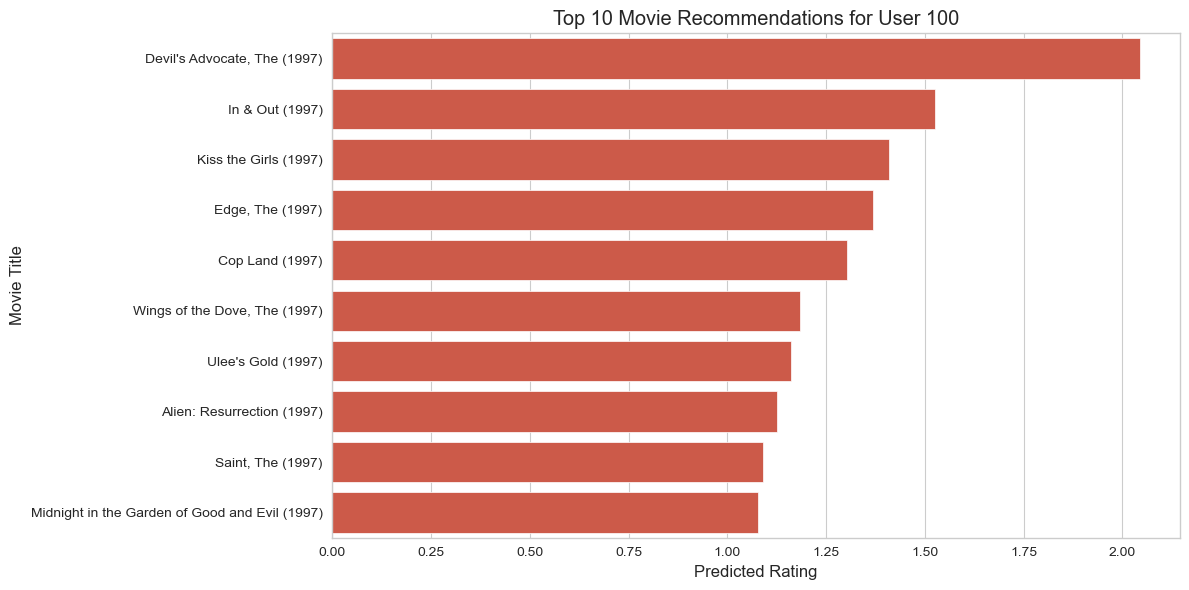

In [23]:
# Visualize top recommended movies for a sample user
sample_user_id = 100
recommendations = recommend_movies_svd(sample_user_id, 10)

plt.figure(figsize=(12, 6))
sns.barplot(x='predicted_rating', y='title', data=recommendations)
plt.title(f'Top 10 Movie Recommendations for User {sample_user_id}')
plt.xlabel('Predicted Rating')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

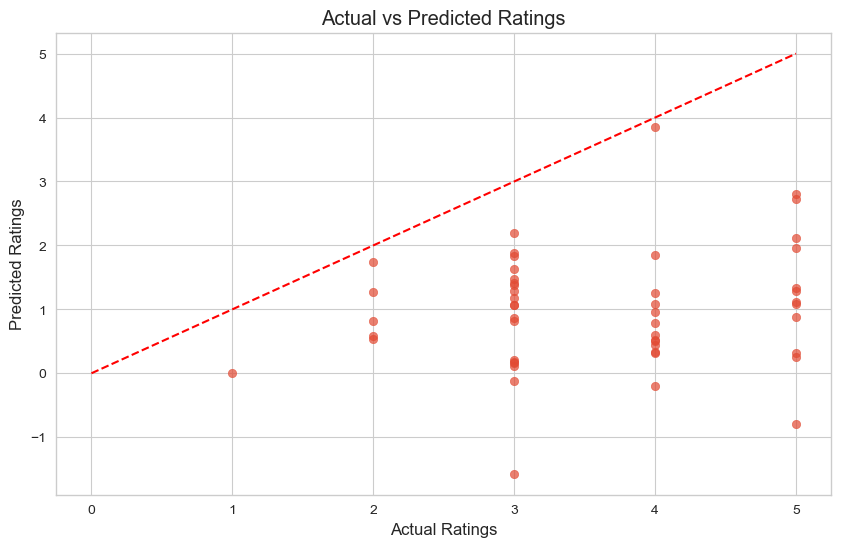

In [24]:
# Compare actual vs predicted ratings for a sample of test data
sample_test = test_data.sample(50)
sample_predictions = []
sample_actuals = []

for _, row in sample_test.iterrows():
    user_id, movie_id = row['user_id'], row['movie_id']
    if user_id in preds_df.index and movie_id in preds_df.columns:
        sample_predictions.append(preds_df.loc[user_id, movie_id])
        sample_actuals.append(row['rating'])

plt.figure(figsize=(10, 6))
plt.scatter(sample_actuals, sample_predictions, alpha=0.7)
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.grid(True)
plt.show()

## 10. Conclusion

In this notebook, we implemented a movie recommendation system using collaborative filtering techniques:

1. **Matrix Factorization (SVD)**: We used Singular Value Decomposition to decompose the user-item matrix into latent factors and generate personalized recommendations.
2. **User-Based Collaborative Filtering**: We calculated user similarities and used them to predict ratings based on similar users' preferences.

Our evaluation metrics show that the SVD-based approach provides reasonable predictions with an RMSE of around 1.0, which is considered good for a 5-point rating scale.

### Potential Improvements:

1. **Hybrid Approaches**: Combine collaborative filtering with content-based filtering using movie features.
2. **Advanced Algorithms**: Implement more sophisticated algorithms like Neural Collaborative Filtering or Factorization Machines.
3. **Hyperparameter Tuning**: Optimize the number of latent factors and other parameters.
4. **Cold Start Problem**: Address the cold start problem for new users and items.

This recommendation system can be integrated into a movie streaming platform to enhance user experience by providing personalized movie suggestions.